In [1]:
import pandas as pd 
import numpy as np
import glob
import os
import math
import scipy.stats as stats
from scipy.stats import pearsonr
from sklearn.decomposition import FactorAnalysis
import pingouin as pg
import semopy
import statsmodels.api as sm
from sklearn import linear_model
from mlxtend.feature_selection import SequentialFeatureSelector
from statsmodels.multivariate.manova import MANOVA
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from scipy.stats import f_oneway, kruskal
import seaborn as sns
from statsmodels.stats.inter_rater import fleiss_kappa

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Read CSV
tam_df = pd.read_csv('tam_results/tam.csv')
demographics = pd.read_csv('demographic_results/demographics_processed.csv')

In [3]:
# Merge
tam_df = pd.merge(tam_df, demographics[['user_id', 'user_archetype', 'age_new', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']])
# Move columns 
col = tam_df.pop('q28')
tam_df.insert(23, col.name, col)
col = tam_df.pop('q29')
tam_df.insert(24, col.name, col)
# Update column names
tam_df.columns = ['user_id',
 'user_archetype',
 'ai_attitude',
 'PU1',
 'PU2',
 'PU3',
 'PU4',
 'PU5',
 'PU6',
 'PU7',
 'PU8',
 'PEOU1',
 'PU9',
 'PEOU2',
 'SE1',
 'SE2',
 'voluntary',
 'SN1',
 'SN2',
 'prestige_image',
 'PU10',
 'PU11',
 'BC1',
 'BC2',
 'BC3',
 'clinical_workflow',
 'infrastructure',
 'intention',
 'colleagues',
 'PU12',
 'final_comments',
 'age_new',
 'sex_new',
 'medical_speciality_new',
 'grade_new',
 'ai_familiarity_new']

# Get result columns 
tam_df_results = tam_df.iloc[:,2:30]

In [86]:
# Save final comments
#tam_df['final_comments'].to_csv('final_comments.csv')

In [4]:
tam_df_results

,ai_attitude,PU1,PU2,PU3,PU4,PU5,PU6,PU7,PU8,PEOU1,...,PU10,PU11,BC1,BC2,BC3,clinical_workflow,infrastructure,intention,colleagues,PU12
0,4,5,2,4,5,4,4,5,4,4,...,4,4,4,NaN,NaN,2,3,4,3,5
1,4,4,4,5,1,5,5,5,4,2,...,3,2,2,NaN,NaN,5,1,5,4,5
2,4,3,4,5,5,3,3,3,4,4,...,3,3,4,NaN,NaN,4,3,3,3,4
3,4,4,4,3,4,4,4,3,4,4,...,4,4,4,NaN,NaN,4,3,4,4,4
4,3,3,4,4,4,4,2,4,4,4,...,4,4,1,NaN,NaN,4,4,4,3,4
5,4,3,2,2,4,2,2,2,3,4,...,3,4,1,NaN,NaN,3,4,3,3,4
6,4,5,3,4,4,4,4,4,4,4,...,4,4,3,NaN,NaN,4,4,4,3,5
7,3,4,2,4,4,4,4,4,3,3,...,3,4,3,4.0,4.0,4,4,4,3,4
8,4,3,2,4,4,4,4,4,4,4,...,3,2,2,4.0,4.0,4,3,4,2,4
9,2,3,2,2,4,3,3,3,3,2,...,3,2,2,3.0,2.0,3,2,2,3,2


In [39]:
# Transform for latex table

# Step 1: Melt the DataFrame
melted_df = tam_df_results.melt(var_name='Question', value_name='Value')

# Step 2: Group by Question and Value, and count occurrences
grouped = melted_df.groupby(['Question', 'Value']).size().unstack(fill_value=0)

# Step 3: Add the missing columns (1 to 5) if they don't exist
for i in range(1, 6):
    if i not in grouped.columns:
        grouped[i] = 0

# Step 4: Calculate the percentage
grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Step 5: Combine count and percentage
latex_result = grouped.astype(str) + " (" + grouped_percentage.round(0).astype(str) + "%)"

# Step 6: Reorder columns to ensure they're in the correct order
latex_result = latex_result[[1, 2, 3, 4, 5]]

# Step 7: Rename columns
latex_result.columns = ['Strongly disagree', 'Disagree', 'Neither agree nor disagree', 'Agree', 'Strongly agree']

# Step 8: Logical ordering of rows
logical_order = ['PU1', 'PU2', 'PU3', 'PU4', 'PU5', 'PU6', 'PU7', 'PU8', 'PU9','PU10', 'PU11', 'PU12',
    'PEOU1', 'PEOU2', 'SE1', 'SE2',  'SN1', 'SN2', 'BC1', 'BC2', 'BC3', 
    'voluntary', 'prestige_image', 'clinical_workflow', 'infrastructure', 'ai_attitude', 'intention', 'colleagues'
]
latex_result = latex_result.reindex(logical_order)

# Step 9: Reset index and rename
latex_result.reset_index(inplace=True)
latex_result.rename(columns={'Question': 'TAM category'}, inplace=True)

# Step 10: Add questions
question_list = [
    'I liked using the AI CDSS',
    'I prefered making IV-to-oral switch decisions with the AI CDSS versus without',
    'In my job using this AI CDSS would be relevant',
    'The data presented in this study is important for delivering care and prescribing antibiotics',
    'I would find the AI CDSS useful in my job',
    'Using this AI CDSS in my job would increase my productivity',
    'Using this AI CDSS would make it easier to do my job',
    'This AI CDSS could improve the quality of care that I deliver',
    'I prefered using this interface for antibiotic decision making over software I currently use in clinical practice',
    'The quality of the AI CDSS predictions was high',
    'Details such as similar patients and their features improved my trust in the AI CDSS',
    'Overall, I think this AI CDSS has the potential to be a useful tool for antibiotic intravenous-to-oral switch decision making',
    'The interface was pleasant with information clearly visible',
    'It was easy to understand recommendations given by the AI CDSS',
    'It was easy to get acquainted using the AI',
    'Training on the AI CDSS was sufficient',
    'Patients will welcome that I use this AI technology',
    'People who are important to me think I should use AI technology',
    'Using the AI CDSS changed my decision making',
    'I was reassured when my clinical decision aligned with the AI CDSS recommendation',
    'I investigated further when my clinical decision was different from the AI CDSS recommendation',
    'My use of the AI CDSS was voluntary',
    'People in my organization involved in AI research have more prestige than those who do not',
    'This AI CDSS could be seamlessly integrated into my current clinical workflow',
    'I think my healthcare institution has the necessary infrastructure to support this AI CDSS',
    'I feel comfortable with AI technology in healthcare',
    'Assuming I had access to the AI CDSS, I would intend to use it',
    'How many of your colleagues would use this AI CDSS if it were implemented',
]


latex_result['Question'] = question_list
col_to_move = latex_result.pop('Question')
latex_result.insert(1, 'Question', col_to_move)

In [40]:
latex_result

,TAM category,Question,Strongly disagree,Disagree,Neither agree nor disagree,Agree,Strongly agree
0,PU1,I liked using the AI CDSS,0 (0.0%),0 (0.0%),13 (31.0%),26 (62.0%),3 (7.0%)
1,PU2,I prefered making IV-to-oral switch decisions ...,0 (0.0%),13 (31.0%),11 (26.0%),16 (38.0%),2 (5.0%)
2,PU3,In my job using this AI CDSS would be relevant,0 (0.0%),3 (7.0%),7 (17.0%),24 (57.0%),8 (19.0%)
3,PU4,The data presented in this study is important ...,1 (2.0%),3 (7.0%),6 (14.0%),22 (52.0%),10 (24.0%)
4,PU5,I would find the AI CDSS useful in my job,0 (0.0%),4 (10.0%),5 (12.0%),26 (62.0%),7 (17.0%)
5,PU6,Using this AI CDSS in my job would increase my...,0 (0.0%),9 (21.0%),12 (29.0%),15 (36.0%),6 (14.0%)
6,PU7,Using this AI CDSS would make it easier to do ...,1 (2.0%),7 (17.0%),10 (24.0%),18 (43.0%),6 (14.0%)
7,PU8,This AI CDSS could improve the quality of care...,0 (0.0%),3 (7.0%),9 (21.0%),26 (62.0%),4 (10.0%)
8,PU9,I prefered using this interface for antibiotic...,1 (2.0%),10 (24.0%),16 (38.0%),13 (31.0%),2 (5.0%)
9,PU10,The quality of the AI CDSS predictions was high,0 (0.0%),3 (7.0%),22 (52.0%),17 (40.0%),0 (0.0%)


# PU

In [6]:
# PU
pu_df = tam_df_results.filter(regex='PU')
# Mean and std
pu_df.mean().mean()
pu_df.mean().std()
pu_df.std().mean()

3.591269841269842

0.3084118109246874

0.8396236489376613

In [7]:
# Create df for demographic analysis
#combined_pu_df = pd.DataFrame(pu_df.mean(axis=1), columns=['pu_mean']).join(demographics[['user_archetype', 'age_new', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']])
# Create df for demographic analysis
combined_pu_df = pd.DataFrame(pu_df.mean(axis=1), columns=['pu_mean']).join(tam_df['user_id'])
combined_pu_df = combined_pu_df.merge(demographics[['user_id', 'user_archetype', 'age_new', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']])


# Imputation with Mode for categorical columns
combined_pu_df['age_new'].fillna(combined_pu_df['age_new'].mode()[0], inplace=True)
combined_pu_df['sex_new'].fillna(combined_pu_df['sex_new'].mode()[0], inplace=True)
combined_pu_df['medical_speciality_new'].fillna(combined_pu_df['medical_speciality_new'].mode()[0], inplace=True)
combined_pu_df['grade_new'].fillna(combined_pu_df['grade_new'].mode()[0], inplace=True)
combined_pu_df['ai_familiarity_new'].fillna(combined_pu_df['ai_familiarity_new'].mode()[0], inplace=True)

# Drop
combined_pu_df.drop(columns='user_id', inplace=True)

In [8]:
combined_pu_df

,pu_mean,user_archetype,age_new,sex_new,medical_speciality_new,grade_new,ai_familiarity_new
0,4.166667,a,30s,Male,Pharmacist,Other,Slightly familiar
1,3.833333,b,30s,Male,Infectious Diseases,Other,Slightly familiar
2,3.500000,a,30s,Male,Infectious Diseases,Other,Slightly familiar
3,3.833333,b,30s,Female,Infectious Diseases,Other,Not familiar
4,3.666667,a,30s,Male,Other,Consultant,Slightly familiar
5,2.833333,b,40s,Male,Other,Consultant,Moderately familiar
6,4.083333,a,40s,Male,Pharmacist,Consultant,Slightly familiar
7,3.583333,b,30s,Female,Pharmacist,Other,Moderately familiar
8,3.500000,a,30s,Female,Pharmacist,Other,Slightly familiar
9,2.750000,b,40s,Male,Microbiology,Consultant,Slightly familiar


In [9]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import f_oneway, kruskal, shapiro, levene
from statsmodels.stats.multitest import multipletests

def anova_kw_test_with_correction(df, column, correction_method='fdr_bh'):
    # Test for normality (Shapiro-Wilk test on residuals)
    model = smf.ols(f"{column} ~ user_archetype + age_new + sex_new + medical_speciality_new + grade_new + ai_familiarity_new", data=df).fit()
    shapiro_stat, shapiro_p_value = shapiro(model.resid)

    # Levene's test for homogeneity of variances
    levene_p_values = {}

    independent_vars = ['user_archetype', 'age_new', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']
    
    for var in independent_vars:
        groups = [df[column][df[var] == group] for group in df[var].dropna().unique()]
        levene_stat, levene_p = levene(*groups)
        levene_p_values[var] = levene_p

    # Determine whether to use ANOVA or Kruskal-Wallis
    if shapiro_p_value >= 0.05 and all(p >= 0.05 for p in levene_p_values.values()):
        anova_bool = True
    else:
        anova_bool = False

    print('\n')
    print(f"ANOVA Assumption Met: {anova_bool}")
    print('\n')

    # Collect results for correction
    results = []
    valid_p_values = []
    p_indices = []  

    # Perform Collective ANOVA
    if anova_bool:
        print('Collective ANOVA')
        model = smf.ols(f"{column} ~ user_archetype + age_new + sex_new + medical_speciality_new + grade_new + ai_familiarity_new", data=df).fit()
        aov_table = sm.stats.anova_lm(model, typ=2)

        for index, row in aov_table.iterrows():
            sum_sq, df_value, f_value, pr_f = row
            results.append({'variable': index, 'test': 'ANOVA', 'statistic': f_value, 'p_value': pr_f})
            if not np.isnan(pr_f):
                valid_p_values.append(pr_f)
                p_indices.append(len(results) - 1)

    # Function to perform ANOVA
    def perform_anova(df, group_var):
        groups = [df[column][df[group_var] == group] for group in df[group_var].dropna().unique()]
        stat, p_value = f_oneway(*groups)
        return stat, p_value

    # Function to perform Kruskal-Wallis H test
    def perform_kruskal(df, group_var):
        groups = [df[column][df[group_var] == group] for group in df[group_var].dropna().unique()]
        stat, p_value = kruskal(*groups)
        return stat, p_value

    print('\nIndependent Tests')
    for var in independent_vars:
        if anova_bool:
            stat, p_value = perform_anova(df, var)
            test_name = 'ANOVA'
        else:
            stat, p_value = perform_kruskal(df, var)
            test_name = 'Kruskal-Wallis'
        
        results.append({'variable': var, 'test': test_name, 'statistic': stat, 'p_value': p_value})
        if not np.isnan(p_value):
            valid_p_values.append(p_value)
            p_indices.append(len(results) - 1)

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Apply multiple comparisons correction
    if valid_p_values:  
        reject, corrected_p_values, _, _ = multipletests(valid_p_values, alpha=0.05, method=correction_method)

        # Insert corrected p-values at correct indices
        for idx, corrected_p, reject_flag in zip(p_indices, corrected_p_values, reject):
            results_df.at[idx, 'p_corrected'] = corrected_p
            results_df.at[idx, 'reject'] = reject_flag

    # Fill missing corrected p-values with NaN
    results_df['p_corrected'].fillna(np.nan, inplace=True)
    results_df['reject'].fillna(False, inplace=True)

    # Print results
    for _, row in results_df.iterrows():
        print(f"{row['test']} for {row['variable']}: Statistic={row['statistic']:.4f}, p-value={row['p_value']:.4f}, Corrected p-value={row['p_corrected']:.4f}")
        if row['reject']:
            print(f"  -> The differences in {row['variable']} remain statistically significant after correction.\n")
        else:
            print(f"  -> The differences in {row['variable']} are no longer statistically significant after correction.\n")

    return results_df

# Run test with correction
anova_kw_results = anova_kw_test_with_correction(combined_pu_df, 'pu_mean')




ANOVA Assumption Met: False



Independent Tests
Kruskal-Wallis for user_archetype: Statistic=0.0002, p-value=0.9899, Corrected p-value=0.9899
  -> The differences in user_archetype are no longer statistically significant after correction.

Kruskal-Wallis for age_new: Statistic=5.4021, p-value=0.2485, Corrected p-value=0.4749
  -> The differences in age_new are no longer statistically significant after correction.

Kruskal-Wallis for sex_new: Statistic=1.0029, p-value=0.3166, Corrected p-value=0.4749
  -> The differences in sex_new are no longer statistically significant after correction.

Kruskal-Wallis for medical_speciality_new: Statistic=2.2652, p-value=0.5192, Corrected p-value=0.6231
  -> The differences in medical_speciality_new are no longer statistically significant after correction.

Kruskal-Wallis for grade_new: Statistic=3.0311, p-value=0.0817, Corrected p-value=0.4749
  -> The differences in grade_new are no longer statistically significant after correction.

Kruskal-Wal

/tmp/ipykernel_13665/2512175579.py:89: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_df.at[idx, 'reject'] = reject_flag


In [10]:
anova_kw_results[['reject']].value_counts()
anova_kw_results[['p_corrected']].value_counts()
anova_kw_results
anova_kw_results[anova_kw_results['p_corrected'] < 0.5]

reject
False     6
Name: count, dtype: int64

p_corrected
0.474921       4
0.623060       1
0.989932       1
Name: count, dtype: int64

,variable,test,statistic,p_value,p_corrected,reject
0,user_archetype,Kruskal-Wallis,0.000159,0.989932,0.989932,False
1,age_new,Kruskal-Wallis,5.402129,0.248467,0.474921,False
2,sex_new,Kruskal-Wallis,1.002882,0.316614,0.474921,False
3,medical_speciality_new,Kruskal-Wallis,2.265218,0.519217,0.623060,False
4,grade_new,Kruskal-Wallis,3.031053,0.081685,0.474921,False
5,ai_familiarity_new,Kruskal-Wallis,4.097808,0.251094,0.474921,False


,variable,test,statistic,p_value,p_corrected,reject
1,age_new,Kruskal-Wallis,5.402129,0.248467,0.474921,False
2,sex_new,Kruskal-Wallis,1.002882,0.316614,0.474921,False
4,grade_new,Kruskal-Wallis,3.031053,0.081685,0.474921,False
5,ai_familiarity_new,Kruskal-Wallis,4.097808,0.251094,0.474921,False


# Functions

In [8]:
def anova_kw_test(df, column):
    # Test for normality
    model = smf.ols(f"{column} ~ user_archetype + age_new + sex_new + medical_speciality_new + grade_new + ai_familiarity_new", data=df).fit()
    shapiro_stat, shapiro_p_value = stats.shapiro(model.resid)
    print(f"Shapiro test: W-statistic={shapiro_stat}, p-value={shapiro_p_value}")
    stats.normaltest(model.resid)
    stats.kstest(model.resid, 'norm')

    # Test for vairance
    # Levene's Test for user_archetype
    levene_archetype_stat, levene_archetype_p_value = stats.levene(df[column][df['user_archetype'] == 'a'],
                        df[column][df['user_archetype'] == 'b'])
    print(f"Levene's test for user_archetype: W-statistic={levene_archetype_stat}, p-value={levene_archetype_p_value}")
    # Levene's Test for age_new
    unique_ages = df['age_new'].unique()
    grouped_ages = [df[column][df['age_new'] == age] for age in unique_ages]
    levene_age_stat, levene_age_p_value = stats.levene(*grouped_ages)
    print(f"Levene's test for age_new: W-statistic={levene_age_stat}, p-value={levene_age_p_value}")
    # Levene's Test for sex_new
    levene_sex_stat, levene_sex_p_value = stats.levene(df[column][df['sex_new'] == 'Male'],
                        df[column][df['sex_new'] == 'Female'])
    print(f"Levene's test for sex_new: W-statistic={levene_sex_stat}, p-value={levene_sex_p_value}")
    # Levene's Test for medical_speciality_new
    unique_medical_specialities = df['medical_speciality_new'].unique()
    grouped_medical_specialities = [df[column][df['medical_speciality_new'] == speciality] for speciality in unique_medical_specialities]
    levene_speciality_stat, levene_speciality_p_value = stats.levene(*grouped_medical_specialities)
    print(f"Levene's test for medical_speciality_new: W-statistic={levene_speciality_stat}, p-value={levene_speciality_p_value}")
    # Levene's Test for grade_new
    unique_grades = df['grade_new'].unique()
    grouped_grades = [df[column][df['grade_new'] == grade] for grade in unique_grades]
    levene_grade_stat, levene_grade_p_value = stats.levene(*grouped_grades)
    print(f"Levene's test for grade_new: W-statistic={levene_grade_stat}, p-value={levene_grade_p_value}")
    # Levene's Test for ai_familiarity_new
    unique_ais = df['ai_familiarity_new'].unique()
    grouped_ais = [df[column][df['ai_familiarity_new'] == ai] for ai in unique_ais]
    levene_ai_stat, levene_ai_p_value = stats.levene(*grouped_ais)
    print(f"Levene's test for ai_familiarity_new: W-statistic={levene_ai_stat}, p-value={levene_ai_p_value}")

    if shapiro_p_value >= 0.05 and levene_archetype_p_value >=0.05 and levene_age_p_value >=0.05 and levene_sex_p_value >= 0.05 and levene_speciality_p_value >=0.05 and levene_grade_p_value >= 0.05 and levene_ai_p_value >= 0.05:
        anova_bool = True
    else:
        anova_bool = False

    print('\n')
    print('anova_bool:', anova_bool)
    print('\n')

    # Perform the appropriate test
    # Do anover independantly for each variable and collectivly 
    if anova_bool:
        print('Collective')
        model = ols(f"{column} ~ user_archetype + age_new + sex_new + medical_speciality_new + grade_new + ai_familiarity_new", data=df).fit()
        aov_table = sm.stats.anova_lm(model, typ=2)
        # Interpretation
        for index, row in aov_table.iterrows():
            sum_sq, df_value, f_value, pr_f = row
            if pr_f < 0.05:
                print(f"ANOVA for {index}: Statistic={f_value:.4f}, p-value={pr_f:.4f}")
                print(f"  -> The differences in {index} are statistically significant.\n")
            #else:
            #    print(f"  -> The differences in {index} are ***NOT*** statistically significant.\n")

    # Function to perform ANOVA
    def perform_anova(df, group_var):
        groups = df.groupby(group_var)[column].apply(list)
        stat, p_value = f_oneway(*groups)
        return stat, p_value

    # Function to perform Kruskal-Wallis H test
    def perform_kruskal(df, group_var):
        groups = df.groupby(group_var)[column].apply(list)
        stat, p_value = kruskal(*groups)
        return stat, p_value

    print('\nIndependant')
    independent_vars = ['user_archetype', 'age_new', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']
    results = {}
    for var in independent_vars:
        if anova_bool:
            stat, p_value = perform_anova(df, var)
            test_name = 'ANOVA'
        else:
            stat, p_value = perform_kruskal(df, var)
            test_name = 'Kruskal-Wallis'
        results[var] = {'test': test_name, 'statistic': stat, 'p_value': p_value}

    # Print the results
    for var, result in results.items():
        if result['p_value'] < 0.05:
            print(f"{result['test']} for {var}: Statistic={result['statistic']:.4f}, p-value={result['p_value']:.4f}")
            print(f"  -> The differences in {var} are statistically significant.\n")
        #else:
        #    print(f"  -> The differences in {var} are ***NOT*** statistically significant.\n")

In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import f_oneway, kruskal, shapiro, levene
from statsmodels.stats.multitest import multipletests

def anova_kw_test_with_correction(df, column, correction_method='holm'):
    # Test for normality (Shapiro-Wilk test on residuals)
    model = smf.ols(f"{column} ~ user_archetype + age_new + sex_new + medical_speciality_new + grade_new + ai_familiarity_new", data=df).fit()
    shapiro_stat, shapiro_p_value = shapiro(model.resid)

    # Levene's test for homogeneity of variances
    levene_p_values = {}

    independent_vars = ['user_archetype', 'age_new', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']
    
    for var in independent_vars:
        groups = [df[column][df[var] == group] for group in df[var].dropna().unique()]
        levene_stat, levene_p = levene(*groups)
        levene_p_values[var] = levene_p

    # Determine whether to use ANOVA or Kruskal-Wallis
    if shapiro_p_value >= 0.05 and all(p >= 0.05 for p in levene_p_values.values()):
        anova_bool = True
    else:
        anova_bool = False

    print('\n')
    print(f"ANOVA Assumption Met: {anova_bool}")
    print('\n')

    # Collect results for correction
    results = []
    valid_p_values = []
    p_indices = []  

    # Perform Collective ANOVA
    if anova_bool:
        print('Collective ANOVA')
        model = smf.ols(f"{column} ~ user_archetype + age_new + sex_new + medical_speciality_new + grade_new + ai_familiarity_new", data=df).fit()
        aov_table = sm.stats.anova_lm(model, typ=2)

        for index, row in aov_table.iterrows():
            sum_sq, df_value, f_value, pr_f = row
            results.append({'variable': index, 'test': 'ANOVA', 'statistic': f_value, 'p_value': pr_f})
            if not np.isnan(pr_f):
                valid_p_values.append(pr_f)
                p_indices.append(len(results) - 1)

    # Function to perform ANOVA
    def perform_anova(df, group_var):
        groups = [df[column][df[group_var] == group] for group in df[group_var].dropna().unique()]
        stat, p_value = f_oneway(*groups)
        return stat, p_value

    # Function to perform Kruskal-Wallis H test
    def perform_kruskal(df, group_var):
        groups = [df[column][df[group_var] == group] for group in df[group_var].dropna().unique()]
        stat, p_value = kruskal(*groups)
        return stat, p_value

    print('\nIndependent Tests')
    for var in independent_vars:
        if anova_bool:
            stat, p_value = perform_anova(df, var)
            test_name = 'ANOVA'
        else:
            stat, p_value = perform_kruskal(df, var)
            test_name = 'Kruskal-Wallis'
        
        results.append({'variable': var, 'test': test_name, 'statistic': stat, 'p_value': p_value})
        if not np.isnan(p_value):
            valid_p_values.append(p_value)
            p_indices.append(len(results) - 1)

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Apply multiple comparisons correction
    if valid_p_values:  
        reject, corrected_p_values, _, _ = multipletests(valid_p_values, alpha=0.05, method=correction_method)

        # Insert corrected p-values at correct indices
        for idx, corrected_p, reject_flag in zip(p_indices, corrected_p_values, reject):
            results_df.at[idx, 'p_corrected'] = corrected_p
            results_df.at[idx, 'reject'] = reject_flag

    # Fill missing corrected p-values with NaN
    results_df['p_corrected'].fillna(np.nan, inplace=True)
    results_df['reject'].fillna(False, inplace=True)

    # Print results
    for _, row in results_df.iterrows():
        print(f"{row['test']} for {row['variable']}: Statistic={row['statistic']:.4f}, p-value={row['p_value']:.4f}, Corrected p-value={row['p_corrected']:.4f}")
        if row['reject']:
            print(f"  -> The differences in {row['variable']} remain statistically significant after correction.\n")
        else:
            print(f"  -> The differences in {row['variable']} are no longer statistically significant after correction.\n")

    return results_df

In [9]:
def bar_plot(df, cat_col, question='TBC'):
    # Define the mapping of numbers to labels
    labels = {1: 'Strongly disagree', 2: 'Disagree', 3: 'Neither agree nor disagree', 4: 'Agree', 5: 'Strongly agree'}

    # Map the data to the labels
    data_labels = df[cat_col].map(labels)

    # Count the occurrences of each label and convert to percentages
    label_counts = data_labels.value_counts(normalize=True).reindex(labels.values(), fill_value=0) * 100

    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    bars = label_counts.plot(kind='bar', color='skyblue')
    plt.ylabel('Percentage of respondents')
    if question != 'TBC':
        plt.title(question)
    plt.xticks(rotation=45)
    plt.ylim(0, 100)  # Set the y-axis limit to 0-100%

    # Annotate bars with percentage values
    for bar in bars.patches:
        height = bar.get_height()
        plt.annotate(f'{height:.0f}%', 
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords='offset points',
                     ha='center', va='bottom')

    plt.show()

In [10]:
def bar_plot_difference(df, cat_col, color_col, question='TBC'):
    # Define the mapping of numbers to labels
    labels = {1: 'Strongly disagree', 2: 'Disagree', 3: 'Neither agree nor disagree', 4: 'Agree', 5: 'Strongly agree'}
    
    # Map the data to the labels
    df['label'] = df[cat_col].map(labels)
    
    # Calculate total counts for overall percentage annotation
    total_counts = df['label'].value_counts(normalize=True).reindex(labels.values(), fill_value=0) * 100
    
    # Initialize an empty DataFrame for stacking
    stacked_data = pd.DataFrame(index=labels.values())

    # Populate the stacked_data DataFrame
    for category in df[color_col].unique():
        subset = df[df[color_col] == category]
        label_counts = subset['label'].value_counts().reindex(labels.values(), fill_value=0)
        stacked_data[category] = label_counts

    # Convert the stacked data into percentages of the total rows
    stacked_data = (stacked_data / len(df)) * 100

    # Define colors for the bars
    colors = ['skyblue', 'cornflowerblue', 'lightcoral', 'olivedrab', 'slategrey']

    # Plot the stacked bar chart
    plt.figure(figsize=(10, 6))
    bottom = None
    bar_width = 0.5  # Set the bar width to be narrower

    for i, category in enumerate(stacked_data.columns):
        bars = plt.bar(stacked_data.index, stacked_data[category], bottom=bottom, 
                       color=colors[i % len(colors)], alpha=0.7, width=bar_width, label=category)
        bottom = stacked_data[category] if bottom is None else bottom + stacked_data[category]

    # Annotate bars with individual segment percentage values
    for i, bar in enumerate(plt.gca().patches):
        height = bar.get_height()
        if height > 0:  # Only annotate if there is a visible bar
            plt.annotate(f'{height:.0f}%', 
                         xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2),
                         xytext=(0, 0),  # Center the text on the bar
                         textcoords='offset points',
                         ha='center', va='center')

    # Annotate bars with overall percentage values
    overall_bars = plt.bar(stacked_data.index, total_counts, width=bar_width, color='none', edgecolor='none')
    for bar in overall_bars:
        height = bar.get_height()
        if height > 0:  # Only annotate if there is a visible bar
            plt.annotate(f'{height:.0f}%', 
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3),  # 3 points vertical offset
                         textcoords='offset points',
                         ha='center', va='bottom')

    # Set labels and title
    plt.ylabel('Percentage of respondents')
    if question != 'TBC':
        plt.title(question)
    plt.xticks(rotation=45)
    plt.ylim(0, 100)  # Set the y-axis limit to 0-100%
    
    # Add legend
    plt.legend(title=color_col)
    
    plt.show()

# Example usage

In [20]:
# Create df
updated_tam_df = tam_df.copy()
# Imputation with Mode for categorical columns
updated_tam_df['age_new'].fillna(updated_tam_df['age_new'].mode()[0], inplace=True)
updated_tam_df['sex_new'].fillna(updated_tam_df['sex_new'].mode()[0], inplace=True)
updated_tam_df['medical_speciality_new'].fillna(updated_tam_df['medical_speciality_new'].mode()[0], inplace=True)
updated_tam_df['grade_new'].fillna(updated_tam_df['grade_new'].mode()[0], inplace=True)
updated_tam_df['ai_familiarity_new'].fillna(updated_tam_df['ai_familiarity_new'].mode()[0], inplace=True)

# Impute for BC
updated_tam_df['BC2'].fillna(updated_tam_df['BC2'].mode()[0], inplace=True)
updated_tam_df['BC3'].fillna(updated_tam_df['BC3'].mode()[0], inplace=True)


In [12]:
updated_tam_df.columns

Index(['user_id', 'user_archetype', 'ai_attitude', 'PU1', 'PU2', 'PU3', 'PU4',
       'PU5', 'PU6', 'PU7', 'PU8', 'PEOU1', 'PU9', 'PEOU2', 'SE1', 'SE2',
       'voluntary', 'SN1', 'SN2', 'prestige_image', 'PU10', 'PU11', 'BC1',
       'BC2', 'BC3', 'clinical_workflow', 'infrastructure', 'intention',
       'colleagues', 'PU12', 'final_comments', 'age_new', 'sex_new',
       'medical_speciality_new', 'grade_new', 'ai_familiarity_new'],
      dtype='object')

# PEOU

In [12]:
# PU
peou_df = tam_df_results.filter(regex='PEOU')
# Mean and std
peou_df.mean().mean()
peou_df.mean().std()
peou_df.std().mean()

3.8333333333333335

0.20203050891044205

0.7701480432760782

In [13]:
# Create df for demographic analysis
combined_peou_df = pd.DataFrame(peou_df.mean(axis=1), columns=['peou_mean']).join(tam_df['user_id'])
combined_peou_df = combined_peou_df.merge(demographics[['user_id', 'user_archetype', 'age_new', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']])


# Imputation with Mode for categorical columns
combined_peou_df['age_new'].fillna(combined_peou_df['age_new'].mode()[0], inplace=True)
combined_peou_df['sex_new'].fillna(combined_peou_df['sex_new'].mode()[0], inplace=True)
combined_peou_df['medical_speciality_new'].fillna(combined_peou_df['medical_speciality_new'].mode()[0], inplace=True)
combined_peou_df['grade_new'].fillna(combined_peou_df['grade_new'].mode()[0], inplace=True)
combined_peou_df['ai_familiarity_new'].fillna(combined_peou_df['ai_familiarity_new'].mode()[0], inplace=True)

# Drop
combined_peou_df.drop(columns='user_id', inplace=True)

In [14]:
anova_kw_results = anova_kw_test_with_correction(combined_peou_df, 'peou_mean')

anova_kw_results[['reject']].value_counts()
anova_kw_results[['p_corrected']].value_counts()
anova_kw_results
anova_kw_results[anova_kw_results['p_corrected'] < 0.5]



ANOVA Assumption Met: True


Collective ANOVA

Independent Tests
ANOVA for user_archetype: Statistic=0.0014, p-value=0.9705, Corrected p-value=1.0000
  -> The differences in user_archetype are no longer statistically significant after correction.

ANOVA for age_new: Statistic=0.2207, p-value=0.9246, Corrected p-value=1.0000
  -> The differences in age_new are no longer statistically significant after correction.

ANOVA for sex_new: Statistic=0.0762, p-value=0.7845, Corrected p-value=1.0000
  -> The differences in sex_new are no longer statistically significant after correction.

ANOVA for medical_speciality_new: Statistic=0.9693, p-value=0.4211, Corrected p-value=1.0000
  -> The differences in medical_speciality_new are no longer statistically significant after correction.

ANOVA for grade_new: Statistic=1.0685, p-value=0.3101, Corrected p-value=1.0000
  -> The differences in grade_new are no longer statistically significant after correction.

ANOVA for ai_familiarity_new: Statistic=

/tmp/ipykernel_13665/1138633129.py:87: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_df.at[idx, 'reject'] = reject_flag


reject
False     13
Name: count, dtype: int64

p_corrected
1.0            12
Name: count, dtype: int64

,variable,test,statistic,p_value,p_corrected,reject
0,user_archetype,ANOVA,0.001396,0.970461,1.0,False
1,age_new,ANOVA,0.220684,0.924628,1.0,False
2,sex_new,ANOVA,0.076235,0.784493,1.0,False
3,medical_speciality_new,ANOVA,0.969267,0.421071,1.0,False
4,grade_new,ANOVA,1.068546,0.310120,1.0,False
5,ai_familiarity_new,ANOVA,0.895354,0.455792,1.0,False
6,Residual,ANOVA,NaN,NaN,NaN,False
7,user_archetype,ANOVA,0.000000,1.000000,1.0,False
8,age_new,ANOVA,0.605824,0.660909,1.0,False
9,sex_new,ANOVA,0.025392,0.874197,1.0,False


,variable,test,statistic,p_value,p_corrected,reject


# SE

In [15]:
# SE
se_df = tam_df_results.filter(regex='SE')
# Mean and std
se_df.mean().mean()
se_df.mean().std()
se_df.std().mean()

4.059523809523809

0.05050762722761036

0.5148535103384044

In [16]:
# Create df for demographic analysis
combined_se_df = pd.DataFrame(se_df.mean(axis=1), columns=['se_mean']).join(tam_df['user_id'])
combined_se_df = combined_se_df.merge(demographics[['user_id', 'user_archetype', 'age_new', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']])


# Imputation with Mode for categorical columns
combined_se_df['age_new'].fillna(combined_se_df['age_new'].mode()[0], inplace=True)
combined_se_df['sex_new'].fillna(combined_se_df['sex_new'].mode()[0], inplace=True)
combined_se_df['medical_speciality_new'].fillna(combined_se_df['medical_speciality_new'].mode()[0], inplace=True)
combined_se_df['grade_new'].fillna(combined_se_df['grade_new'].mode()[0], inplace=True)
combined_se_df['ai_familiarity_new'].fillna(combined_se_df['ai_familiarity_new'].mode()[0], inplace=True)

# Drop
combined_se_df.drop(columns='user_id', inplace=True)

# Round for plot
combined_se_df['se_mean_round'] = combined_se_df['se_mean'].apply(lambda x: math.ceil(x))

In [17]:
anova_kw_results = anova_kw_test_with_correction(combined_se_df, 'se_mean')

anova_kw_results[['reject']].value_counts()
anova_kw_results[['p_corrected']].value_counts()
anova_kw_results
anova_kw_results[anova_kw_results['p_corrected'] < 0.5]



ANOVA Assumption Met: True


Collective ANOVA

Independent Tests
ANOVA for user_archetype: Statistic=0.9848, p-value=0.3295, Corrected p-value=1.0000
  -> The differences in user_archetype are no longer statistically significant after correction.

ANOVA for age_new: Statistic=0.7822, p-value=0.5463, Corrected p-value=1.0000
  -> The differences in age_new are no longer statistically significant after correction.

ANOVA for sex_new: Statistic=0.2075, p-value=0.6523, Corrected p-value=1.0000
  -> The differences in sex_new are no longer statistically significant after correction.

ANOVA for medical_speciality_new: Statistic=0.6638, p-value=0.5813, Corrected p-value=1.0000
  -> The differences in medical_speciality_new are no longer statistically significant after correction.

ANOVA for grade_new: Statistic=1.7320, p-value=0.1988, Corrected p-value=1.0000
  -> The differences in grade_new are no longer statistically significant after correction.

ANOVA for ai_familiarity_new: Statistic=

/tmp/ipykernel_13665/1138633129.py:87: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_df.at[idx, 'reject'] = reject_flag


reject
False     13
Name: count, dtype: int64

p_corrected
1.000000       10
0.473886        1
0.816976        1
Name: count, dtype: int64

,variable,test,statistic,p_value,p_corrected,reject
0,user_archetype,ANOVA,0.984799,0.329516,1.000000,False
1,age_new,ANOVA,0.782170,0.546335,1.000000,False
2,sex_new,ANOVA,0.207450,0.652286,1.000000,False
3,medical_speciality_new,ANOVA,0.663829,0.581272,1.000000,False
4,grade_new,ANOVA,1.731985,0.198831,1.000000,False
5,ai_familiarity_new,ANOVA,3.175188,0.039491,0.473886,False
6,Residual,ANOVA,NaN,NaN,NaN,False
7,user_archetype,ANOVA,0.031348,0.860360,1.000000,False
8,age_new,ANOVA,0.203581,0.934801,1.000000,False
9,sex_new,ANOVA,1.392152,0.245012,1.000000,False


,variable,test,statistic,p_value,p_corrected,reject
5,ai_familiarity_new,ANOVA,3.175188,0.039491,0.473886,False


# SN

In [18]:
# SE
sn_df = tam_df_results.filter(regex='SN')
# Mean and std
sn_df.mean().mean()
sn_df.mean().std()
sn_df.std().mean()

3.2023809523809526

0.11785113019775781

0.611865231373107

In [21]:
anova_kw_results = anova_kw_test_with_correction(updated_tam_df, 'SN2')

anova_kw_results[['reject']].value_counts()
anova_kw_results[['p_corrected']].value_counts()
anova_kw_results
anova_kw_results[anova_kw_results['p_corrected'] < 0.5]



ANOVA Assumption Met: False



Independent Tests
Kruskal-Wallis for user_archetype: Statistic=0.4304, p-value=0.5118, Corrected p-value=1.0000
  -> The differences in user_archetype are no longer statistically significant after correction.

Kruskal-Wallis for age_new: Statistic=6.4606, p-value=0.1673, Corrected p-value=0.8364
  -> The differences in age_new are no longer statistically significant after correction.

Kruskal-Wallis for sex_new: Statistic=3.9090, p-value=0.0480, Corrected p-value=0.2882
  -> The differences in sex_new are no longer statistically significant after correction.

Kruskal-Wallis for medical_speciality_new: Statistic=1.0154, p-value=0.7975, Corrected p-value=1.0000
  -> The differences in medical_speciality_new are no longer statistically significant after correction.

Kruskal-Wallis for grade_new: Statistic=0.1091, p-value=0.7412, Corrected p-value=1.0000
  -> The differences in grade_new are no longer statistically significant after correction.

Kruskal-Wal

/tmp/ipykernel_13665/1138633129.py:87: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_df.at[idx, 'reject'] = reject_flag


reject
False     6
Name: count, dtype: int64

p_corrected
1.000000       4
0.288173       1
0.836435       1
Name: count, dtype: int64

,variable,test,statistic,p_value,p_corrected,reject
0,user_archetype,Kruskal-Wallis,0.430391,0.511797,1.000000,False
1,age_new,Kruskal-Wallis,6.460647,0.167287,0.836435,False
2,sex_new,Kruskal-Wallis,3.908974,0.048029,0.288173,False
3,medical_speciality_new,Kruskal-Wallis,1.015388,0.797529,1.000000,False
4,grade_new,Kruskal-Wallis,0.109051,0.741227,1.000000,False
5,ai_familiarity_new,Kruskal-Wallis,2.905476,0.406430,1.000000,False


,variable,test,statistic,p_value,p_corrected,reject
2,sex_new,Kruskal-Wallis,3.908974,0.048029,0.288173,False


# BC

In [22]:
# BC
bc_df = tam_df_results.filter(regex='BC')
# Mean and std
bc_df.mean().mean()
bc_df.mean().std()
bc_df.std().mean()

3.46031746031746

0.6967585027731611

0.8835978101207845

In [23]:
anova_kw_results = anova_kw_test_with_correction(updated_tam_df, 'BC3')

anova_kw_results[['reject']].value_counts()
anova_kw_results[['p_corrected']].value_counts()
anova_kw_results
anova_kw_results[anova_kw_results['p_corrected'] < 0.5]



ANOVA Assumption Met: False



Independent Tests
Kruskal-Wallis for user_archetype: Statistic=2.3518, p-value=0.1251, Corrected p-value=0.6257
  -> The differences in user_archetype are no longer statistically significant after correction.

Kruskal-Wallis for age_new: Statistic=9.8089, p-value=0.0438, Corrected p-value=0.2626
  -> The differences in age_new are no longer statistically significant after correction.

Kruskal-Wallis for sex_new: Statistic=0.6652, p-value=0.4147, Corrected p-value=0.9429
  -> The differences in sex_new are no longer statistically significant after correction.

Kruskal-Wallis for medical_speciality_new: Statistic=2.3349, p-value=0.5059, Corrected p-value=0.9429
  -> The differences in medical_speciality_new are no longer statistically significant after correction.

Kruskal-Wallis for grade_new: Statistic=1.0125, p-value=0.3143, Corrected p-value=0.9429
  -> The differences in grade_new are no longer statistically significant after correction.

Kruskal-Wal

/tmp/ipykernel_13665/1138633129.py:87: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_df.at[idx, 'reject'] = reject_flag


reject
False     6
Name: count, dtype: int64

p_corrected
0.942950       3
0.625689       2
0.262641       1
Name: count, dtype: int64

,variable,test,statistic,p_value,p_corrected,reject
0,user_archetype,Kruskal-Wallis,2.351809,0.125138,0.625689,False
1,age_new,Kruskal-Wallis,9.808857,0.043774,0.262641,False
2,sex_new,Kruskal-Wallis,0.665191,0.414733,0.942950,False
3,medical_speciality_new,Kruskal-Wallis,2.334923,0.505864,0.942950,False
4,grade_new,Kruskal-Wallis,1.012450,0.314317,0.942950,False
5,ai_familiarity_new,Kruskal-Wallis,5.333464,0.148946,0.625689,False


,variable,test,statistic,p_value,p_corrected,reject
1,age_new,Kruskal-Wallis,9.808857,0.043774,0.262641,False


# Others

In [123]:
# ai_attitude
updated_tam_df['ai_attitude'].mean()
updated_tam_df['ai_attitude'].std()
anova_kw_test(updated_tam_df, 'ai_attitude')

3.5714285714285716

0.6678270969037458

Shapiro test: W-statistic=0.9411352276802063, p-value=0.03130989894270897
Levene's test for user_archetype: W-statistic=3.525179856115108, p-value=0.06774868270636089
Levene's test for age_new: W-statistic=0.5788075560802833, p-value=0.6798099155463716
Levene's test for sex_new: W-statistic=0.21276312814989154, p-value=0.6471087718839339
Levene's test for medical_speciality_new: W-statistic=0.36340757518560457, p-value=0.7797705011962544
Levene's test for grade_new: W-statistic=0.6529966672315425, p-value=0.42382325046693403
Levene's test for ai_familiarity_new: W-statistic=0.7620716510903428, p-value=0.5223936489829011


anova_bool: False



Independant


In [24]:
anova_kw_results = anova_kw_test_with_correction(updated_tam_df, 'ai_attitude')

anova_kw_results[['reject']].value_counts()
anova_kw_results[['p_corrected']].value_counts()
anova_kw_results
anova_kw_results[anova_kw_results['p_corrected'] < 0.5]



ANOVA Assumption Met: False



Independent Tests
Kruskal-Wallis for user_archetype: Statistic=2.4748, p-value=0.1157, Corrected p-value=0.6941
  -> The differences in user_archetype are no longer statistically significant after correction.

Kruskal-Wallis for age_new: Statistic=5.1354, p-value=0.2737, Corrected p-value=1.0000
  -> The differences in age_new are no longer statistically significant after correction.

Kruskal-Wallis for sex_new: Statistic=1.1202, p-value=0.2899, Corrected p-value=1.0000
  -> The differences in sex_new are no longer statistically significant after correction.

Kruskal-Wallis for medical_speciality_new: Statistic=1.0130, p-value=0.7981, Corrected p-value=1.0000
  -> The differences in medical_speciality_new are no longer statistically significant after correction.

Kruskal-Wallis for grade_new: Statistic=0.2553, p-value=0.6134, Corrected p-value=1.0000
  -> The differences in grade_new are no longer statistically significant after correction.

Kruskal-Wal

/tmp/ipykernel_13665/1138633129.py:87: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_df.at[idx, 'reject'] = reject_flag


reject
False     6
Name: count, dtype: int64

p_corrected
1.000000       5
0.694108       1
Name: count, dtype: int64

,variable,test,statistic,p_value,p_corrected,reject
0,user_archetype,Kruskal-Wallis,2.474793,0.115685,0.694108,False
1,age_new,Kruskal-Wallis,5.135389,0.273686,1.000000,False
2,sex_new,Kruskal-Wallis,1.120183,0.289879,1.000000,False
3,medical_speciality_new,Kruskal-Wallis,1.013018,0.798102,1.000000,False
4,grade_new,Kruskal-Wallis,0.255264,0.613393,1.000000,False
5,ai_familiarity_new,Kruskal-Wallis,3.328539,0.343690,1.000000,False


,variable,test,statistic,p_value,p_corrected,reject


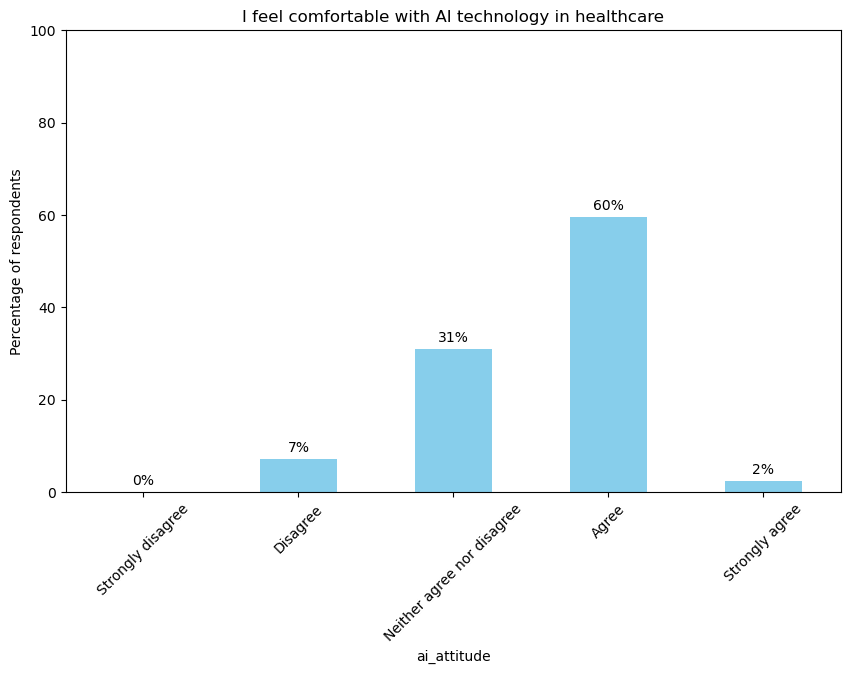

In [124]:
bar_plot(updated_tam_df, 'ai_attitude', 'I feel comfortable with AI technology in healthcare')

In [125]:
from scipy.stats import pearsonr, spearmanr
from scipy.stats import shapiro, levene

# Define the mapping of numbers to labels
labels = {'Not familiar': 1, 'Slightly familiar': 2, 'Moderately familiar': 3, 'Very familiar': 4, 'Extremely familiar': 5}

# Add new column 
updated_tam_df['ai_familiarity'] = updated_tam_df.ai_familiarity_new.map(labels)

# Shapiro-Wilk Test for normality
shapiro_familiarity_stat, shapiro_familiarity_p = shapiro(updated_tam_df['ai_familiarity'])
shapiro_comfort_stat, shapiro_comfort_p = shapiro(updated_tam_df['ai_attitude'])
print(f"Shapiro-Wilk test for familiarity_with_ai: Stat={shapiro_familiarity_stat}, p-value={shapiro_familiarity_p}")
print(f"Shapiro-Wilk test for comfort_with_ai: Stat={shapiro_comfort_stat}, p-value={shapiro_comfort_p}")

# Levene's Test for homogeneity of variances
levene_stat, levene_p = levene(updated_tam_df['ai_familiarity'], updated_tam_df['ai_attitude'])
print(f"Levene's test: Stat={levene_stat}, p-value={levene_p}")

# Pearson correlation
pearson_corr, pearson_p_value = pearsonr(updated_tam_df['ai_familiarity'], updated_tam_df['ai_attitude'])
print(f"Pearson correlation: {pearson_corr}, p-value: {pearson_p_value}")

# Spearman correlation
spearman_corr, spearman_p_value = spearmanr(updated_tam_df['ai_familiarity'], updated_tam_df['ai_attitude'])
print(f"Spearman correlation: {spearman_corr}, p-value: {spearman_p_value}")

Shapiro-Wilk test for familiarity_with_ai: Stat=0.8526661396026611, p-value=7.28485465515405e-05
Shapiro-Wilk test for comfort_with_ai: Stat=0.7617638111114502, p-value=7.449883696608595e-07
Levene's test: Stat=0.47674418604651164, p-value=0.4918505759125368
Pearson correlation: 0.15471055359010535, p-value: 0.32793218989002637
Spearman correlation: 0.15230110823880186, p-value: 0.3356129478580824


Above ^^^ See not correlation between familiarity with AI and if comftable with AI indicating understanding AI is not driving force

4.380952380952381

0.49150743499231997

Shapiro test: W-statistic=0.9489254355430603, p-value=0.05911276862025261
Levene's test for user_archetype: W-statistic=0.0, p-value=1.0
Levene's test for age_new: W-statistic=0.12660393498716854, p-value=0.9718867991352101
Levene's test for sex_new: W-statistic=2.0435255209417433, p-value=0.16061928013433005
Levene's test for medical_speciality_new: W-statistic=1.0808383233532934, p-value=0.36880877643031035
Levene's test for grade_new: W-statistic=0.0036985668053629377, p-value=0.95180872570515
Levene's test for ai_familiarity_new: W-statistic=1.0255041518386714, p-value=0.39215526277823637


anova_bool: True


Collective

Independant


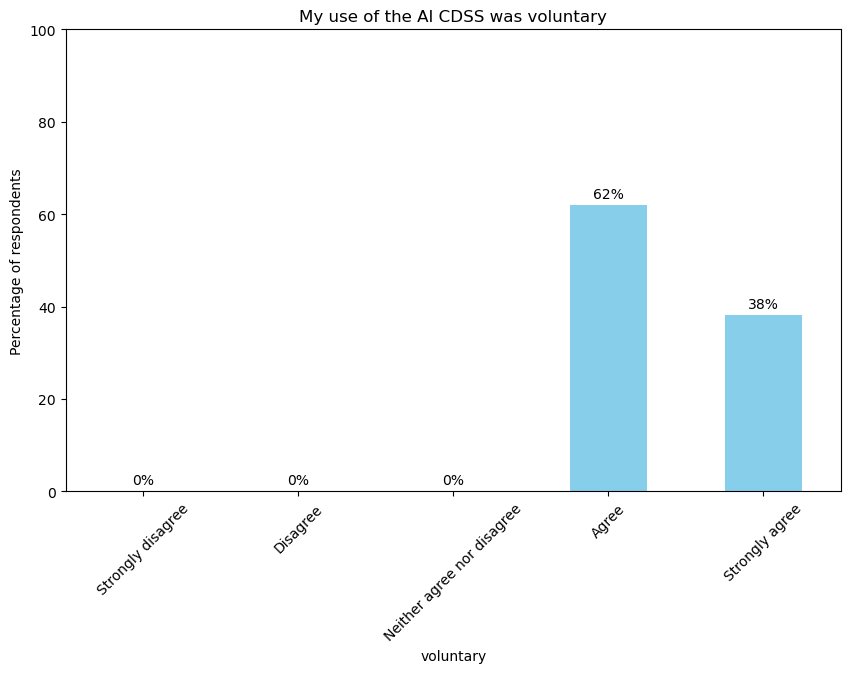

In [126]:
# voluntary
updated_tam_df['voluntary'].mean()
updated_tam_df['voluntary'].std()
anova_kw_test(updated_tam_df, 'voluntary')
bar_plot(updated_tam_df, 'voluntary', 'My use of the AI CDSS was voluntary')

In [25]:
anova_kw_results = anova_kw_test_with_correction(updated_tam_df, 'voluntary')

anova_kw_results[['reject']].value_counts()
anova_kw_results[['p_corrected']].value_counts()
anova_kw_results
anova_kw_results[anova_kw_results['p_corrected'] < 0.5]



ANOVA Assumption Met: True


Collective ANOVA

Independent Tests
ANOVA for user_archetype: Statistic=0.1717, p-value=0.6818, Corrected p-value=1.0000
  -> The differences in user_archetype are no longer statistically significant after correction.

ANOVA for age_new: Statistic=0.4822, p-value=0.7485, Corrected p-value=1.0000
  -> The differences in age_new are no longer statistically significant after correction.

ANOVA for sex_new: Statistic=0.0209, p-value=0.8861, Corrected p-value=1.0000
  -> The differences in sex_new are no longer statistically significant after correction.

ANOVA for medical_speciality_new: Statistic=0.8968, p-value=0.4551, Corrected p-value=1.0000
  -> The differences in medical_speciality_new are no longer statistically significant after correction.

ANOVA for grade_new: Statistic=0.5709, p-value=0.4562, Corrected p-value=1.0000
  -> The differences in grade_new are no longer statistically significant after correction.

ANOVA for ai_familiarity_new: Statistic=

/tmp/ipykernel_13665/1138633129.py:87: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_df.at[idx, 'reject'] = reject_flag


reject
False     13
Name: count, dtype: int64

p_corrected
1.0            12
Name: count, dtype: int64

,variable,test,statistic,p_value,p_corrected,reject
0,user_archetype,ANOVA,0.171675,0.681784,1.0,False
1,age_new,ANOVA,0.482236,0.748539,1.0,False
2,sex_new,ANOVA,0.020883,0.886132,1.0,False
3,medical_speciality_new,ANOVA,0.896752,0.455112,1.0,False
4,grade_new,ANOVA,0.570878,0.456220,1.0,False
5,ai_familiarity_new,ANOVA,0.873600,0.466492,1.0,False
6,Residual,ANOVA,NaN,NaN,NaN,False
7,user_archetype,ANOVA,0.000000,1.000000,1.0,False
8,age_new,ANOVA,0.120130,0.974453,1.0,False
9,sex_new,ANOVA,2.043526,0.160619,1.0,False


,variable,test,statistic,p_value,p_corrected,reject


3.5476190476190474

0.8611501371147363

Shapiro test: W-statistic=0.9586655497550964, p-value=0.13227993249893188
Levene's test for user_archetype: W-statistic=0.35856573705179245, p-value=0.5526801558793604
Levene's test for age_new: W-statistic=0.369431643625192, p-value=0.8288535626646942
Levene's test for sex_new: W-statistic=0.8686460237448995, p-value=0.35692209198514435
Levene's test for medical_speciality_new: W-statistic=1.5294422156076095, p-value=0.2225367619017229
Levene's test for grade_new: W-statistic=0.04599405118263635, p-value=0.8312762105425283
Levene's test for ai_familiarity_new: W-statistic=0.18179795282599015, p-value=0.9081013065164373


anova_bool: True


Collective

Independant


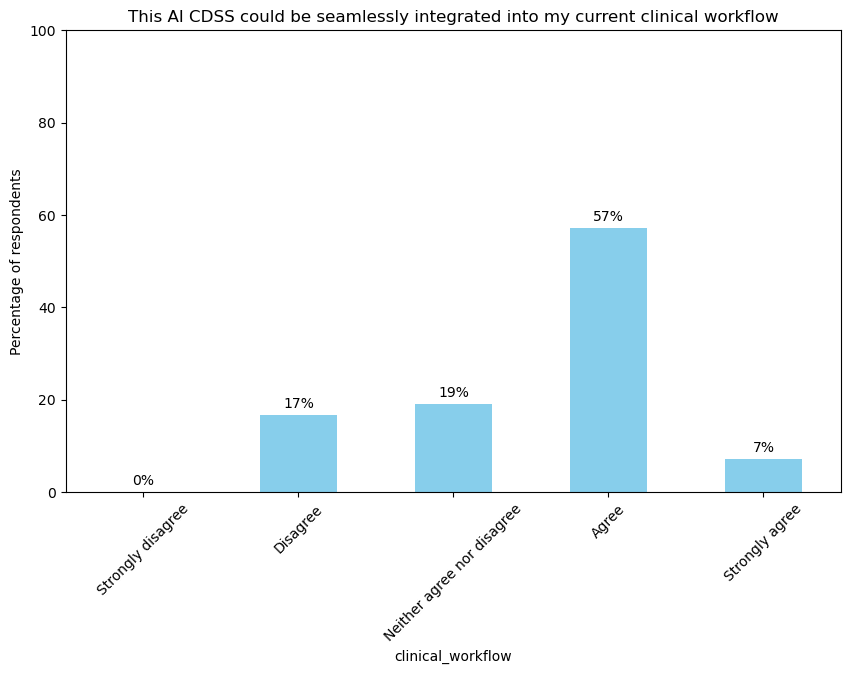

In [127]:
# clinical_workflow
updated_tam_df['clinical_workflow'].mean()
updated_tam_df['clinical_workflow'].std()
anova_kw_test(updated_tam_df, 'clinical_workflow')
bar_plot(updated_tam_df, 'clinical_workflow', 'This AI CDSS could be seamlessly integrated into my current clinical workflow')

In [26]:
anova_kw_results = anova_kw_test_with_correction(updated_tam_df, 'clinical_workflow')

anova_kw_results[['reject']].value_counts()
anova_kw_results[['p_corrected']].value_counts()
anova_kw_results
anova_kw_results[anova_kw_results['p_corrected'] < 0.5]



ANOVA Assumption Met: True


Collective ANOVA

Independent Tests
ANOVA for user_archetype: Statistic=1.7501, p-value=0.1966, Corrected p-value=1.0000
  -> The differences in user_archetype are no longer statistically significant after correction.

ANOVA for age_new: Statistic=0.5760, p-value=0.6824, Corrected p-value=1.0000
  -> The differences in age_new are no longer statistically significant after correction.

ANOVA for sex_new: Statistic=0.0823, p-value=0.7763, Corrected p-value=1.0000
  -> The differences in sex_new are no longer statistically significant after correction.

ANOVA for medical_speciality_new: Statistic=0.6992, p-value=0.5604, Corrected p-value=1.0000
  -> The differences in medical_speciality_new are no longer statistically significant after correction.

ANOVA for grade_new: Statistic=0.0111, p-value=0.9170, Corrected p-value=1.0000
  -> The differences in grade_new are no longer statistically significant after correction.

ANOVA for ai_familiarity_new: Statistic=

/tmp/ipykernel_13665/1138633129.py:87: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_df.at[idx, 'reject'] = reject_flag


reject
False     13
Name: count, dtype: int64

p_corrected
1.0            12
Name: count, dtype: int64

,variable,test,statistic,p_value,p_corrected,reject
0,user_archetype,ANOVA,1.750065,0.196571,1.0,False
1,age_new,ANOVA,0.575984,0.682365,1.0,False
2,sex_new,ANOVA,0.082318,0.776293,1.0,False
3,medical_speciality_new,ANOVA,0.699201,0.560431,1.0,False
4,grade_new,ANOVA,0.011062,0.916984,1.0,False
5,ai_familiarity_new,ANOVA,1.402173,0.262855,1.0,False
6,Residual,ANOVA,NaN,NaN,NaN,False
7,user_archetype,ANOVA,0.798722,0.376822,1.0,False
8,age_new,ANOVA,0.579889,0.679050,1.0,False
9,sex_new,ANOVA,0.020726,0.886251,1.0,False


,variable,test,statistic,p_value,p_corrected,reject


2.7857142857142856

0.8705399021609261

Shapiro test: W-statistic=0.9791750907897949, p-value=0.6297733783721924
Levene's test for user_archetype: W-statistic=0.1923076923076923, p-value=0.6633623210790344
Levene's test for age_new: W-statistic=0.8110837438423646, p-value=0.5261826207813842
Levene's test for sex_new: W-statistic=2.5789754129557743, p-value=0.11615867122728919
Levene's test for medical_speciality_new: W-statistic=0.291913214990138, p-value=0.8309627706831495
Levene's test for grade_new: W-statistic=1.3488719884736744, p-value=0.2523592829285864
Levene's test for ai_familiarity_new: W-statistic=0.48350111856823264, p-value=0.6957260101843386


anova_bool: True


Collective

Independant


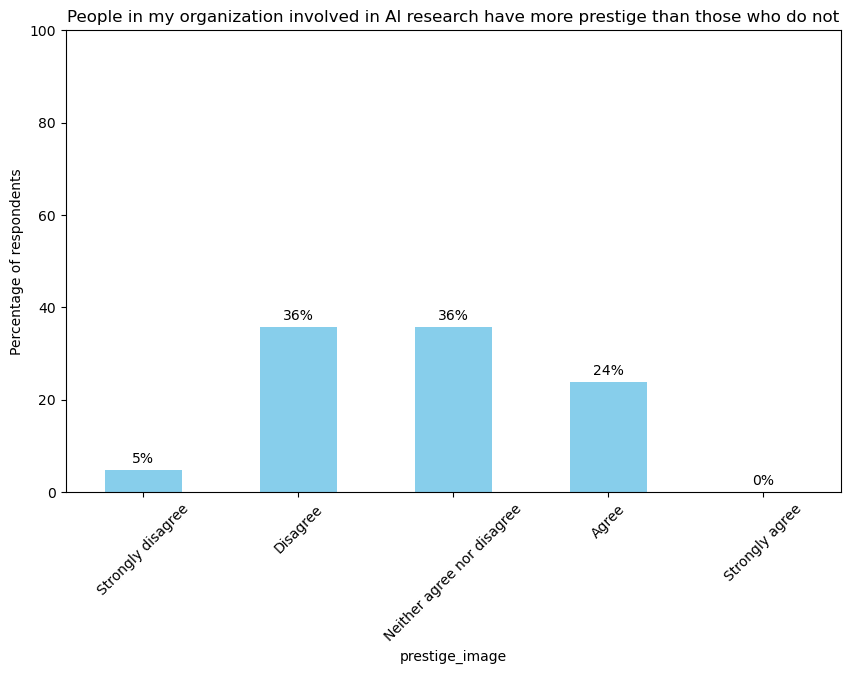

In [128]:
# prestige_image
updated_tam_df['prestige_image'].mean()
updated_tam_df['prestige_image'].std()
anova_kw_test(updated_tam_df, 'prestige_image')
bar_plot(updated_tam_df, 'prestige_image', 'People in my organization involved in AI research have more prestige than those who do not')

In [27]:
anova_kw_results = anova_kw_test_with_correction(updated_tam_df, 'prestige_image')

anova_kw_results[['reject']].value_counts()
anova_kw_results[['p_corrected']].value_counts()
anova_kw_results
anova_kw_results[anova_kw_results['p_corrected'] < 0.5]



ANOVA Assumption Met: True


Collective ANOVA

Independent Tests
ANOVA for user_archetype: Statistic=0.7461, p-value=0.3951, Corrected p-value=1.0000
  -> The differences in user_archetype are no longer statistically significant after correction.

ANOVA for age_new: Statistic=1.2706, p-value=0.3050, Corrected p-value=1.0000
  -> The differences in age_new are no longer statistically significant after correction.

ANOVA for sex_new: Statistic=0.0204, p-value=0.8874, Corrected p-value=1.0000
  -> The differences in sex_new are no longer statistically significant after correction.

ANOVA for medical_speciality_new: Statistic=0.2399, p-value=0.8678, Corrected p-value=1.0000
  -> The differences in medical_speciality_new are no longer statistically significant after correction.

ANOVA for grade_new: Statistic=0.4358, p-value=0.5146, Corrected p-value=1.0000
  -> The differences in grade_new are no longer statistically significant after correction.

ANOVA for ai_familiarity_new: Statistic=

/tmp/ipykernel_13665/1138633129.py:87: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_df.at[idx, 'reject'] = reject_flag


reject
False     13
Name: count, dtype: int64

p_corrected
1.0            12
Name: count, dtype: int64

,variable,test,statistic,p_value,p_corrected,reject
0,user_archetype,ANOVA,0.746080,0.395059,1.0,False
1,age_new,ANOVA,1.270567,0.304995,1.0,False
2,sex_new,ANOVA,0.020403,0.887440,1.0,False
3,medical_speciality_new,ANOVA,0.239890,0.867769,1.0,False
4,grade_new,ANOVA,0.435787,0.514557,1.0,False
5,ai_familiarity_new,ANOVA,0.494418,0.689067,1.0,False
6,Residual,ANOVA,NaN,NaN,NaN,False
7,user_archetype,ANOVA,2.647059,0.111595,1.0,False
8,age_new,ANOVA,1.792461,0.151109,1.0,False
9,sex_new,ANOVA,1.202289,0.279422,1.0,False


,variable,test,statistic,p_value,p_corrected,reject


2.9761904761904763

0.9750070728472727

Shapiro test: W-statistic=0.9855419993400574, p-value=0.8646436333656311
Levene's test for user_archetype: W-statistic=1.5337423312883425, p-value=0.222770712932975
Levene's test for age_new: W-statistic=0.6351052048726468, p-value=0.6406704370332339
Levene's test for sex_new: W-statistic=1.0013027329674595, p-value=0.3230106907098395
Levene's test for medical_speciality_new: W-statistic=0.05570743690320539, p-value=0.9824426455752553
Levene's test for grade_new: W-statistic=0.16486259073860174, p-value=0.6868825677303383
Levene's test for ai_familiarity_new: W-statistic=0.22222222222222232, p-value=0.8803590587149526


anova_bool: True


Collective
ANOVA for sex_new: Statistic=6.4236, p-value=0.0171
  -> The differences in sex_new are statistically significant.

ANOVA for medical_speciality_new: Statistic=6.1767, p-value=0.0023
  -> The differences in medical_speciality_new are statistically significant.


Independant
ANOVA for medical_speciality_new: Statistic=3.2188, p-value=0.0333


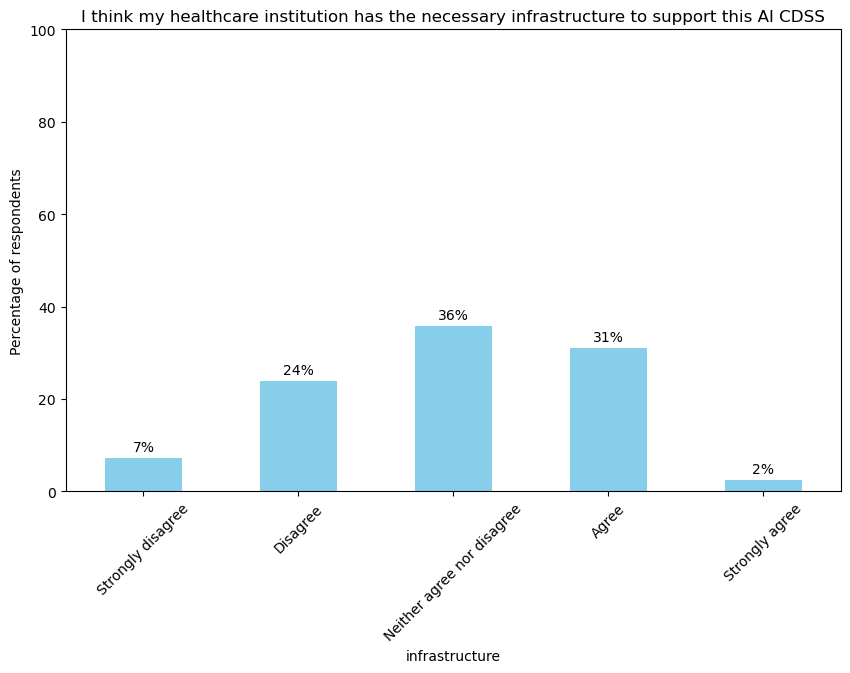

In [130]:
# infrastructure
updated_tam_df['infrastructure'].mean()
updated_tam_df['infrastructure'].std()
anova_kw_test(updated_tam_df, 'infrastructure')
bar_plot(updated_tam_df, 'infrastructure', 'I think my healthcare institution has the necessary infrastructure to support this AI CDSS')

In [28]:
anova_kw_results = anova_kw_test_with_correction(updated_tam_df, 'infrastructure')

anova_kw_results[['reject']].value_counts()
anova_kw_results[['p_corrected']].value_counts()
anova_kw_results
anova_kw_results[anova_kw_results['p_corrected'] < 0.5]



ANOVA Assumption Met: True


Collective ANOVA

Independent Tests
ANOVA for user_archetype: Statistic=1.1138, p-value=0.3003, Corrected p-value=1.0000
  -> The differences in user_archetype are no longer statistically significant after correction.

ANOVA for age_new: Statistic=1.1072, p-value=0.3727, Corrected p-value=1.0000
  -> The differences in age_new are no longer statistically significant after correction.

ANOVA for sex_new: Statistic=6.4236, p-value=0.0171, Corrected p-value=0.1885
  -> The differences in sex_new are no longer statistically significant after correction.

ANOVA for medical_speciality_new: Statistic=6.1767, p-value=0.0023, Corrected p-value=0.0281
  -> The differences in medical_speciality_new remain statistically significant after correction.

ANOVA for grade_new: Statistic=1.7220, p-value=0.2001, Corrected p-value=1.0000
  -> The differences in grade_new are no longer statistically significant after correction.

ANOVA for ai_familiarity_new: Statistic=2.1003,

/tmp/ipykernel_13665/1138633129.py:87: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_df.at[idx, 'reject'] = reject_flag


reject
False     12
True       1
Name: count, dtype: int64

p_corrected
1.000000       9
0.028089       1
0.188487       1
0.333410       1
Name: count, dtype: int64

,variable,test,statistic,p_value,p_corrected,reject
0,user_archetype,ANOVA,1.113778,0.300284,1.000000,False
1,age_new,ANOVA,1.107222,0.372698,1.000000,False
2,sex_new,ANOVA,6.423563,0.017135,0.188487,False
3,medical_speciality_new,ANOVA,6.176709,0.002341,0.028089,True
4,grade_new,ANOVA,1.722035,0.200088,1.000000,False
5,ai_familiarity_new,ANOVA,2.100275,0.122749,1.000000,False
6,Residual,ANOVA,NaN,NaN,NaN,False
7,user_archetype,ANOVA,0.620347,0.435561,1.000000,False
8,age_new,ANOVA,0.688033,0.604854,1.000000,False
9,sex_new,ANOVA,2.055791,0.159400,1.000000,False


,variable,test,statistic,p_value,p_corrected,reject
2,sex_new,ANOVA,6.423563,0.017135,0.188487,False
3,medical_speciality_new,ANOVA,6.176709,0.002341,0.028089,True
10,medical_speciality_new,ANOVA,3.218826,0.033341,0.333410,False


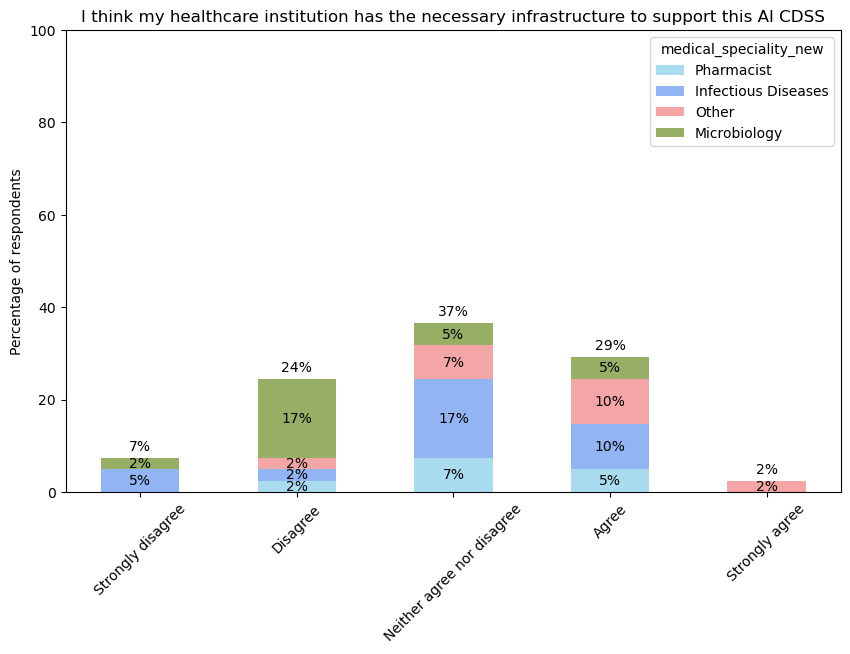

In [58]:
bar_plot_difference(updated_tam_df, 'infrastructure', 'medical_speciality_new', 'I think my healthcare institution has the necessary infrastructure to support this AI CDSS')

3.8095238095238093

0.7066960307707159

Shapiro test: W-statistic=0.9295048117637634, p-value=0.012466751970350742
Levene's test for user_archetype: W-statistic=0.2409638554216867, p-value=0.6261932547102698
Levene's test for age_new: W-statistic=0.5393586005830903, p-value=0.7077273957333681
Levene's test for sex_new: W-statistic=2.7058737473484005, p-value=0.10781654682598325
Levene's test for medical_speciality_new: W-statistic=0.26521982780579756, p-value=0.8500230285136662
Levene's test for grade_new: W-statistic=0.3069202094483849, p-value=0.5826603647940968
Levene's test for ai_familiarity_new: W-statistic=0.8354609929078013, p-value=0.48281752997969796


anova_bool: False



Independant


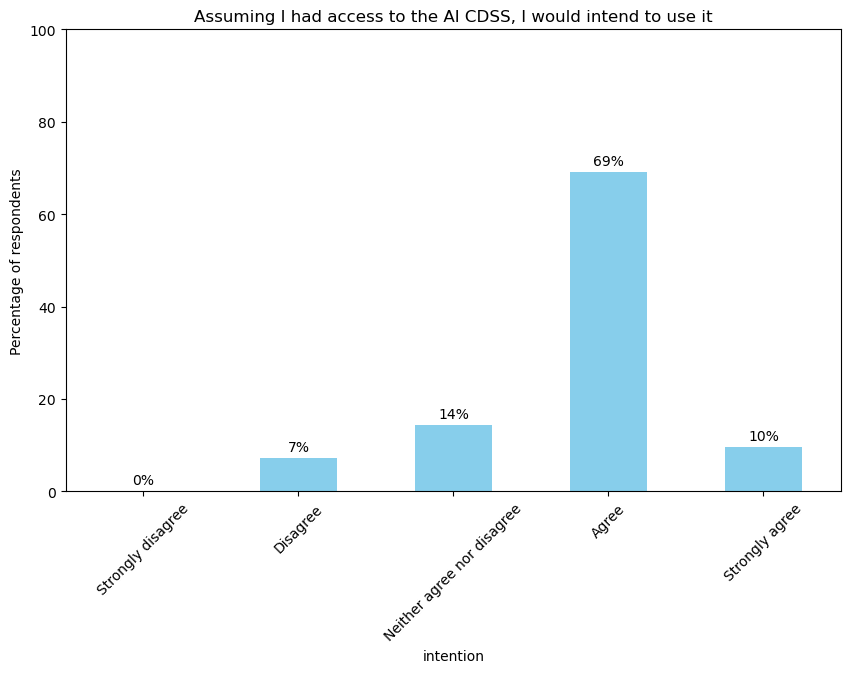

In [131]:
# intention
updated_tam_df['intention'].mean()
updated_tam_df['intention'].std()
anova_kw_test(updated_tam_df, 'intention')
bar_plot(updated_tam_df, 'intention', 'Assuming I had access to the AI CDSS, I would intend to use it')

In [29]:
anova_kw_results = anova_kw_test_with_correction(updated_tam_df, 'intention')

anova_kw_results[['reject']].value_counts()
anova_kw_results[['p_corrected']].value_counts()
anova_kw_results
anova_kw_results[anova_kw_results['p_corrected'] < 0.5]



ANOVA Assumption Met: False



Independent Tests
Kruskal-Wallis for user_archetype: Statistic=1.8366, p-value=0.1753, Corrected p-value=0.7959
  -> The differences in user_archetype are no longer statistically significant after correction.

Kruskal-Wallis for age_new: Statistic=6.1053, p-value=0.1914, Corrected p-value=0.7959
  -> The differences in age_new are no longer statistically significant after correction.

Kruskal-Wallis for sex_new: Statistic=1.9820, p-value=0.1592, Corrected p-value=0.7959
  -> The differences in sex_new are no longer statistically significant after correction.

Kruskal-Wallis for medical_speciality_new: Statistic=2.1192, p-value=0.5480, Corrected p-value=0.7959
  -> The differences in medical_speciality_new are no longer statistically significant after correction.

Kruskal-Wallis for grade_new: Statistic=2.9872, p-value=0.0839, Corrected p-value=0.5036
  -> The differences in grade_new are no longer statistically significant after correction.

Kruskal-Wal

/tmp/ipykernel_13665/1138633129.py:87: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_df.at[idx, 'reject'] = reject_flag


reject
False     6
Name: count, dtype: int64

p_corrected
0.795910       5
0.503566       1
Name: count, dtype: int64

,variable,test,statistic,p_value,p_corrected,reject
0,user_archetype,Kruskal-Wallis,1.836642,0.175345,0.795910,False
1,age_new,Kruskal-Wallis,6.105341,0.191418,0.795910,False
2,sex_new,Kruskal-Wallis,1.981979,0.159182,0.795910,False
3,medical_speciality_new,Kruskal-Wallis,2.119212,0.548036,0.795910,False
4,grade_new,Kruskal-Wallis,2.987153,0.083928,0.503566,False
5,ai_familiarity_new,Kruskal-Wallis,3.942077,0.267787,0.795910,False


,variable,test,statistic,p_value,p_corrected,reject


3.0952380952380953

0.6555401351231357

Shapiro test: W-statistic=0.9799085855484009, p-value=0.6579711437225342
Levene's test for user_archetype: W-statistic=1.5384615384615392, p-value=0.22207351255239627
Levene's test for age_new: W-statistic=2.703380588876772, p-value=0.045154952884750486
Levene's test for sex_new: W-statistic=1.3320197044334974, p-value=0.2552954085713816
Levene's test for medical_speciality_new: W-statistic=0.7188519243313762, p-value=0.5469205003792021
Levene's test for grade_new: W-statistic=0.008014425966740138, p-value=0.9291127759968867
Levene's test for ai_familiarity_new: W-statistic=0.7890710382513665, p-value=0.5075311367307072


anova_bool: False



Independant


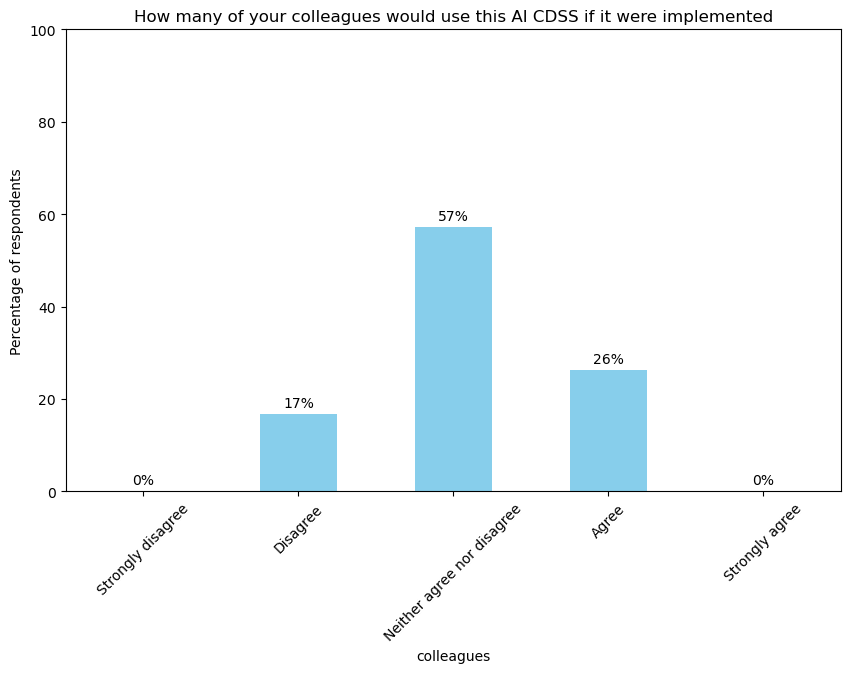

In [132]:
# prestige_image
updated_tam_df['colleagues'].mean()
updated_tam_df['colleagues'].std()
anova_kw_test(updated_tam_df, 'colleagues')
bar_plot(updated_tam_df, 'colleagues', 'How many of your colleagues would use this AI CDSS if it were implemented')

In [30]:
anova_kw_results = anova_kw_test_with_correction(updated_tam_df, 'colleagues')

anova_kw_results[['reject']].value_counts()
anova_kw_results[['p_corrected']].value_counts()
anova_kw_results
anova_kw_results[anova_kw_results['p_corrected'] < 0.5]



ANOVA Assumption Met: False



Independent Tests
Kruskal-Wallis for user_archetype: Statistic=2.1211, p-value=0.1453, Corrected p-value=0.8289
  -> The differences in user_archetype are no longer statistically significant after correction.

Kruskal-Wallis for age_new: Statistic=6.9577, p-value=0.1381, Corrected p-value=0.8289
  -> The differences in age_new are no longer statistically significant after correction.

Kruskal-Wallis for sex_new: Statistic=1.1654, p-value=0.2803, Corrected p-value=1.0000
  -> The differences in sex_new are no longer statistically significant after correction.

Kruskal-Wallis for medical_speciality_new: Statistic=3.3966, p-value=0.3344, Corrected p-value=1.0000
  -> The differences in medical_speciality_new are no longer statistically significant after correction.

Kruskal-Wallis for grade_new: Statistic=0.5089, p-value=0.4756, Corrected p-value=1.0000
  -> The differences in grade_new are no longer statistically significant after correction.

Kruskal-Wal

/tmp/ipykernel_13665/1138633129.py:87: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_df.at[idx, 'reject'] = reject_flag


reject
False     6
Name: count, dtype: int64

p_corrected
1.000000       4
0.828856       2
Name: count, dtype: int64

,variable,test,statistic,p_value,p_corrected,reject
0,user_archetype,Kruskal-Wallis,2.121127,0.145280,0.828856,False
1,age_new,Kruskal-Wallis,6.957661,0.138143,0.828856,False
2,sex_new,Kruskal-Wallis,1.165404,0.280348,1.000000,False
3,medical_speciality_new,Kruskal-Wallis,3.396623,0.334419,1.000000,False
4,grade_new,Kruskal-Wallis,0.508897,0.475617,1.000000,False
5,ai_familiarity_new,Kruskal-Wallis,2.776186,0.427435,1.000000,False


,variable,test,statistic,p_value,p_corrected,reject


# Group plot

In [57]:
import textwrap

def multi_bar_plot(df, cat_cols, questions=None):
    # Define the mapping of numbers to labels
    labels = {1: 'Strongly disagree', 2: 'Disagree', 3: 'Neither agree nor disagree', 4: 'Agree', 5: 'Strongly agree'}

    # Create subplots with 3 rows and 2 columns
    fig, axs = plt.subplots(3, 2, figsize=(15, 15), sharey=True, sharex=True)
    axs = axs.flatten()

    for i, cat_col in enumerate(cat_cols):
        # Map the data to the labels
        data_labels = df[cat_col].map(labels)

        # Count the occurrences of each label and convert to percentages
        label_counts = data_labels.value_counts(normalize=True).reindex(labels.values(), fill_value=0) * 100

        # Plot the bar chart in the respective subplot
        bars = label_counts.plot(kind='bar', color='skyblue', ax=axs[i])
        axs[i].set_ylabel('Percentage of respondents')
        axs[i].set_ylim(0, 100)  # Set the y-axis limit to 0-100%
        axs[i].set_xticklabels(labels.values(), rotation=45, ha='right')

        # Remove the general x-axis label (but keep tick labels)
        axs[i].set_xlabel('')

        # Set the title with text wrapping if provided
        if questions is not None and len(questions) > i:
            wrapped_title = "\n".join(textwrap.wrap(questions[i], width=75))  # Increase width for wrapping
            axs[i].set_title(wrapped_title)
        else:
            axs[i].set_title(cat_col)

        # Annotate bars with percentage values
        for bar in bars.patches:
            height = bar.get_height()
            axs[i].annotate(f'{height:.0f}%',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords='offset points',
                            ha='center', va='bottom')

    # Remove any unused subplots if fewer than 6 columns are provided
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.25)
    plt.show()

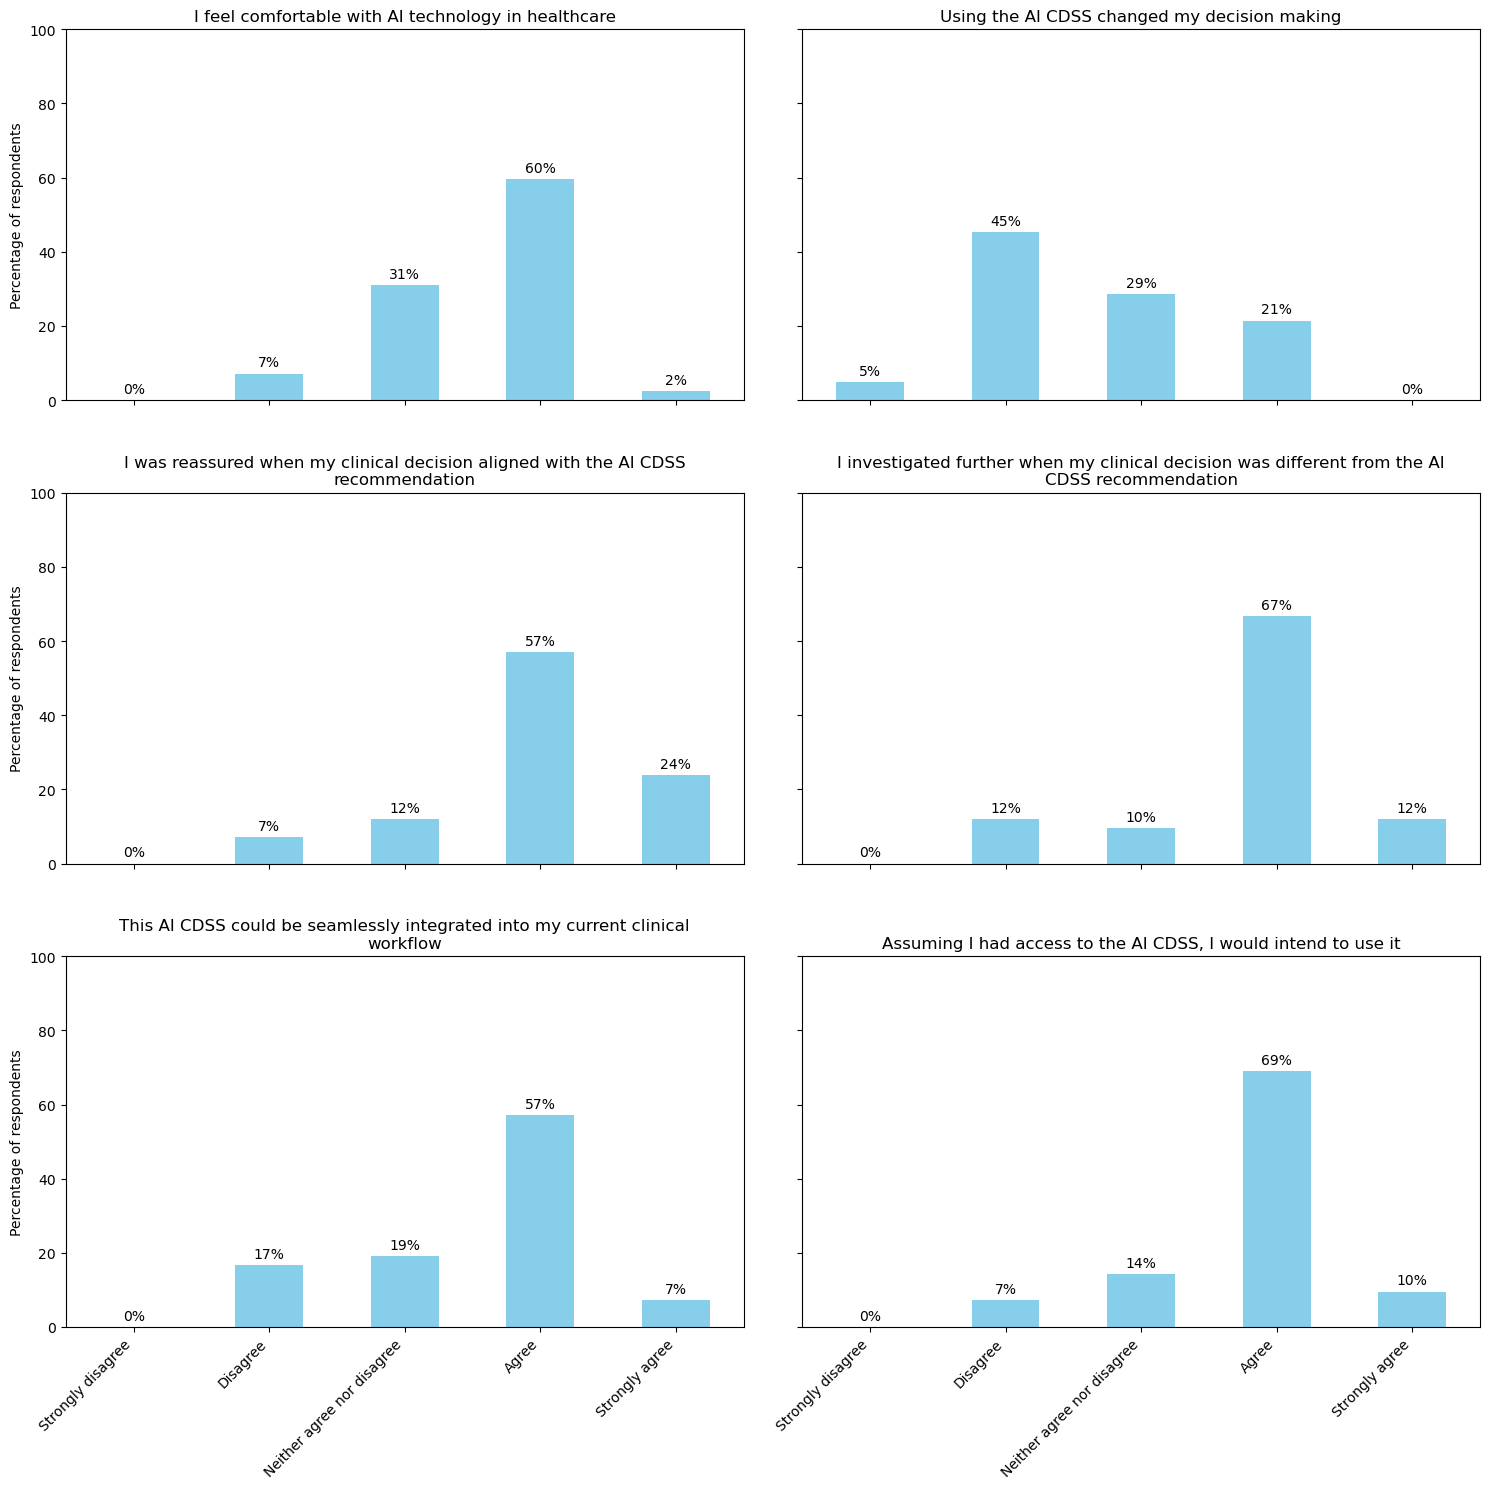

In [58]:
groups_to_plot = ['ai_attitude', 'BC1', 'BC2', 'BC3', 'clinical_workflow', 'intention']
questions = [
'I feel comfortable with AI technology in healthcare',
'Using the AI CDSS changed my decision making',
'I was reassured when my clinical decision aligned with the AI CDSS recommendation',
'I investigated further when my clinical decision was different from the AI CDSS recommendation',
'This AI CDSS could be seamlessly integrated into my current clinical workflow',
'Assuming I had access to the AI CDSS, I would intend to use it'
]

multi_bar_plot(updated_tam_df, groups_to_plot, questions)